# ResNet neural network visualization

Saliency maps and other visualization technics applied to ResNet [2]

In [1]:
import numpy as np
import requests
import tensorflow as tf
import tensorflow.keras.applications.resnet as resnet
from tensorflow.keras import models, optimizers, losses
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from skimage import io, transform

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model

Resnet50 model is loaded from the Keras applications

In [3]:
model0 = resnet.ResNet50(include_top=True, weights='imagenet')
#model0.summary()

## Helpers

In [4]:
def normalizeImage(img):
    """ Normalize image to have pixel values in [0, 1] """
    mi = img.min()
    ma = img.max()
    return (img - mi) / (ma - mi)

def plotSaliencyMap(original, saliencies, activations, activationsAfter, layerNames, title="Input"):
    """ Plot saliency map and comparison to input """
    n = len(saliencies)
    fig, axes = plt.subplots(n, 5, figsize=(14, 4*n), sharey=True)
    if n == 1:
        axes = axes.reshape(1, -1)
        
    axes[0][0].imshow(normalizeImage(original))
    axes[0][0].set_title(title)
    
    for i in range(n):
        axes[i][1].imshow(normalizeImage(saliencies[i]))
        axes[i][1].set_title("%s Saliency" % layerNames[i])
        axes[i][2].imshow(normalizeImage((saliencies[i] - original)))
        axes[i][2].set_title("Saliency - Input")
        act = activations[i]
        if len(act.shape) == 2:
            axes[i][3].imshow(np.clip(act, 0, 1), cmap='gray')
        else:
            axes[i][3].text(0, 0.3, "%.3g" % act)
        axes[i][3].set_title("Activation on origin")
        act = activationsAfter[i]
        if len(act.shape) == 2:
            axes[i][4].imshow(np.clip(act, 0, 1), cmap='gray')
        else:
            axes[i][4].text(0, 0.3, "%.3g" % act)
        axes[i][4].set_title("Activation on saliency")
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)

In [5]:
class ImagenetClasses:
    """ Download Imagenet class listing and provide accessors """
    def __init__(self):
        r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
        self.classes = r.json()
        
    def __getitem__(self, c):
        return self.classes[str(c)]
    
classes = ImagenetClasses()

In [6]:
classes[167]

['n02089973', 'English_foxhound']

## Test the model

Using samples from the Woof subset of Imagenet

Resnet is expecting image with width and height at 224 pixel.

((224, 224, 3), 1.0)

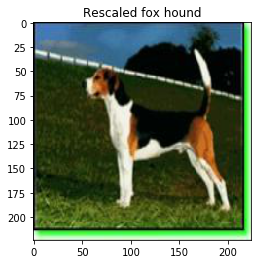

In [7]:
woof = io.imread('assets/imagewoof2-160/train/n02089973/n02089973_9145.JPEG')
woof1 = transform.resize(woof, (224, 224, 3), mode='constant').astype(np.float32)
plt.imshow(woof1)
plt.title('Rescaled fox hound')
woof1.shape, woof1.max()

In [8]:
predWoof = model0.predict(resnet.preprocess_input(np.array([woof1]) * 255)) #  

Max prediction for: ['n02089973', 'English_foxhound'] @ 82.86%


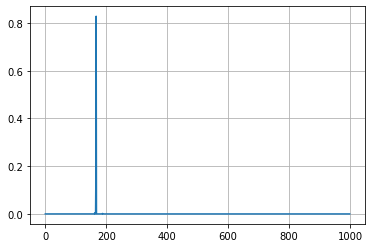

In [9]:
plt.plot(predWoof[0])
plt.grid()
maxProbaIndex = np.argmax(predWoof[0])
print('Max prediction for: %s @ %.2f%%' % (classes[maxProbaIndex], predWoof[0][maxProbaIndex] * 100))

In [10]:
resnet.decode_predictions(predWoof)

[[('n02089973', 'English_foxhound', 0.8286331),
  ('n02089867', 'Walker_hound', 0.16340141),
  ('n02088364', 'beagle', 0.004292194),
  ('n02095314', 'wire-haired_fox_terrier', 0.0020270052),
  ('n02088632', 'bluetick', 0.0003328828)]]

# Saliency end to end

In [11]:
def tvRegularization(img, gradientMean):
    """ Total variation regularization, beta=1 """
    imgPad = tf.pad(img, tf.constant([[0,0], [0,1], [0,1], [0,0]]))
    # ISSUE : not able to backpropagate square root
    rsqDiff = ((img - imgPad[:, 1:, :-1])**2 + (img - imgPad[:, :-1,1:])**2) #**(0.5)
    res = 1/(gradientMean) * tf.math.reduce_mean(rsqDiff)
    #print(res)
    return res

@tf.function
def gradientMinLossStep(model, img, learningRate, lambdaReg, tvRegMeanGrad, trueActivation, loss):
    """ Minimize error using backpropagation """
    with tf.GradientTape() as tape:
        tape.watch(img)
        tape.watch(trueActivation)
        activation = model(img) 
        imgNorm = tf.norm(img, 'euclidean')
        # Loss + regularization
        objective = loss(trueActivation, activation) \
            + tf.cast(lambdaReg * imgNorm**2 + tvRegularization(img, tvRegMeanGrad), tf.float32) #  
      #  print(objective)
    grads = tape.gradient(objective, img)
    
    # Gradient descent to minimize objective (cross entropy)
    img = img - learningRate * grads 
    
    return objective, grads, img, imgNorm

def endToEndSaliency(numEpochs, model, img, learningRate, lambdaReg, tvRegMeanGrad, trueActivation):
    
    imgTf = tf.expand_dims(img, axis=0)
    trueActivationTf = tf.constant(trueActivation.reshape(1, -1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        
    intensityHist, gradHist, imgNorms = [], [], []
    
    for epoch in range(numEpochs):
       
        intensity, grads, imgTf, imgNorm = gradientMinLossStep(model, imgTf, learningRate, 
                                                               lambdaReg, tvRegMeanGrad, 
                                                               trueActivationTf, loss)
        
        intensityHist.append(intensity)
        if epoch % (numEpochs / 10):
            gradHist.append(grads)
        imgNorms.append(imgNorm)
    
    # Only clip the returned saliency image
    return (imgTf[0], intensityHist, gradHist, imgNorms)

### Saliency Starting from a neutral image (grey)

In [13]:
#tvRegularization(tf.expand_dims(woof1Prep, 0), 1e2), tf.shape(tf.constant(woof1Prep))

In [14]:
c = 167
print('Create saliency of %s' % classes[c])
targetActivation = np.array([c * 1.])
mediumGray = np.ones((224, 224, 3), dtype=np.float32) * 0.1
e2eSaliency = endToEndSaliency(100, model0, mediumGray * 255, 1e+4, 1e-8, 1e3, targetActivation)

Create saliency of ['n02089973', 'English_foxhound']


Saliency image min=-78.1, max=177


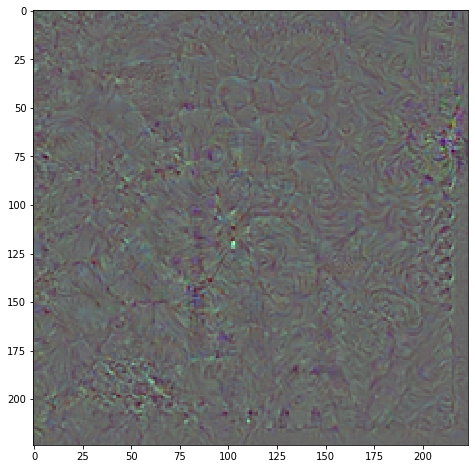

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(normalizeImage(e2eSaliency[0].numpy()));
print("Saliency image min=%.3g, max=%.3g" % (e2eSaliency[0].numpy().min(), e2eSaliency[0].numpy().max()))

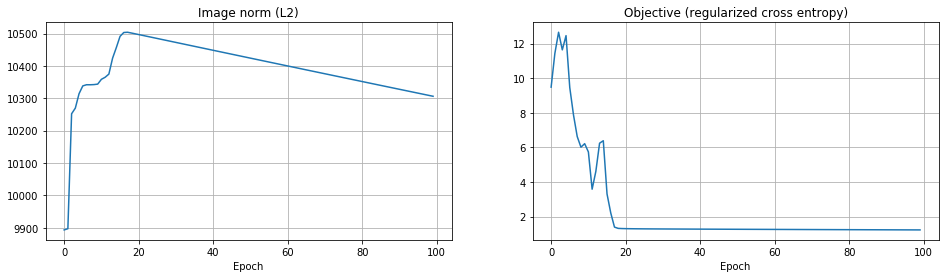

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(e2eSaliency[3])
axes[0].set_xlabel("Epoch")
axes[0].set_title('Image norm (L2)')
axes[0].grid()
axes[1].plot(e2eSaliency[1])
axes[1].set_xlabel("Epoch")
axes[1].set_title('Objective (regularized cross entropy)')
axes[1].grid()

#### Prediction on the salient image

In [17]:
predSaliency = model0.predict(np.array([e2eSaliency[0]]))
resnet.decode_predictions(predSaliency)

[[('n02089973', 'English_foxhound', 0.99854195),
  ('n02089867', 'Walker_hound', 0.00060530927),
  ('n02088364', 'beagle', 0.00050876674),
  ('n02088238', 'basset', 0.000106829575),
  ('n02088466', 'bloodhound', 6.133923e-05)]]

## Saliency on the input image

In [18]:
@tf.function
def gradientMaxStep(model, img, learningRate, lambdaReg, tvRegMeanGrad, unit=None):
    """ Gradient ascent step in order to maximize the output (on the specified unit if provided)"""
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = model(img)
        # Select unit if any
        if unit is not None:
            if len(activation.shape) == 4:
                activationTarget = activation[:,:,:,unit]  
            else:
                activationTarget = activation[:,unit]
        else:
            activationTarget = activation
        imgNorm =tf.norm(img, 'euclidean')
        reg =  tf.cast(lambdaReg * imgNorm**2 + tvRegularization(img, tvRegMeanGrad), tf.float32)
        # Objective to maximize, with regularization
        objective = tf.norm(activationTarget)**2 - reg
    grads = tape.gradient(objective, img)
    
    # Gradient ascent 
    img = img + learningRate * grads
   
    return img, objective, grads, imgNorm

def getPartialSalient(numEpochs, model, img, learningRate, lambdaReg, tvRegMeanGrad, unit=None):
    """ Saliency computation on part or full network in "unsupervised mode"
         i.e. no target class provided.
        Output is maximized through gradient ascent with regularization (soft constraint on the image norm)
    """
    imgTf = tf.expand_dims(img, axis=0)
    trueActivationTf = None
    loss = None
       
    intensityHist, gradHist, imgNorms = [], [], []
    
    for epoch in range(numEpochs):
       
        imgTf, intensity, grads, imgNorm = gradientMaxStep(model, imgTf, 
                                                           learningRate, lambdaReg, tvRegMeanGrad, 
                                                           unit)
        
        intensityHist.append(intensity)
        if epoch % (numEpochs / 10):
            gradHist.append(grads)
        imgNorms.append(imgNorm)
    
    return (imgTf[0], intensityHist, gradHist, imgNorms)

Dog image in the input format of ResNet

In [19]:
woof1Prep = resnet.preprocess_input(np.array([woof1]) * 255)[0].astype(np.float32)

In [39]:
c = 167
print('Create saliency of %s starting from a foxhound image' % classes[c])
targetActivation = np.array([c * 1.])
e2eSaliencyFH = getPartialSalient(20, model0, woof1Prep*0.1, 1e4, 1e-15, 1e5)

Create saliency of ['n02089973', 'English_foxhound'] starting from a foxhound image


In [42]:
predSaliencyFH = model0.predict(np.array([e2eSaliencyFH[0]]))
resnet.decode_predictions(predSaliencyFH)

[[('n07248320', 'book_jacket', 0.9998543),
  ('n03291819', 'envelope', 4.7322057e-05),
  ('n02892201', 'brass', 2.000021e-05),
  ('n04589890', 'window_screen', 1.3473723e-05),
  ('n04275548', 'spider_web', 6.091819e-06)]]

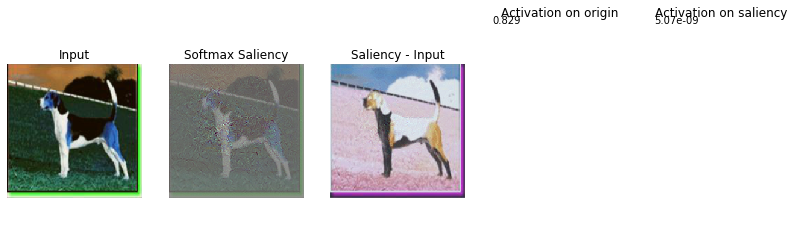

In [43]:
plotSaliencyMap(woof1Prep, [e2eSaliencyFH[0].numpy()], 
                [predWoof[0][c]], [predSaliencyFH[0][c]], layerNames=['Softmax'])

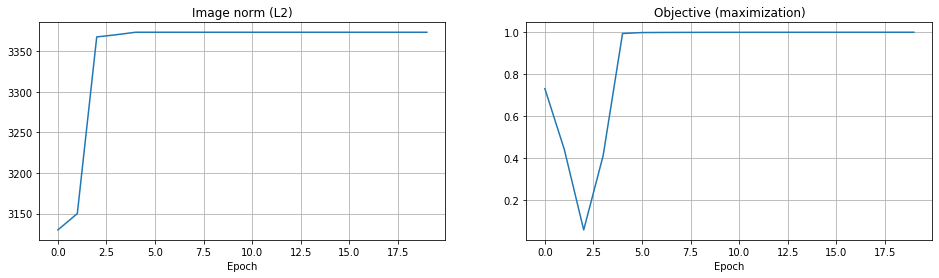

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(e2eSaliencyFH[3])
axes[0].set_xlabel("Epoch")
axes[0].set_title('Image norm (L2)')
axes[0].grid()
axes[1].plot(e2eSaliencyFH[1])
axes[1].set_xlabel("Epoch")
axes[1].set_title('Objective (maximization)')
axes[1].grid()

In [24]:
%whos

Variable              Type               Data/Info
--------------------------------------------------
ImagenetClasses       type               <class '__main__.ImagenetClasses'>
ax                    AxesSubplot        AxesSubplot(0.135,0.125;0.755x0.755)
axes                  ndarray            2: 2 elems, type `object`, 16 bytes
c                     int                167
classes               ImagenetClasses    <__main__.ImagenetClasses object at 0x1c5c163890>
e2eSaliency           tuple              n=4
e2eSaliencyFH         tuple              n=4
endToEndSaliency      function           <function endToEndSaliency at 0x1c652593b0>
fig                   Figure             Figure(1152x288)
getPartialSalient     function           <function getPartialSalient at 0x1c68bb1d40>
gradientMaxStep       Function           <tensorflow.python.eager.<...>n object at 0x1c68bae990>
gradientMinLossStep   Function           <tensorflow.python.eager.<...>n object at 0x1c6526a650>
image             

## References

1. [Dog subset of Imagenet]( https://github.com/fastai/imagenette)
2. [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
3. [Axiomatic attribution for deep neuron networks](https://arxiv.org/abs/1703.01365), Sundararajan et al., 2017